<a href="https://colab.research.google.com/github/GCioa123/PatternFlow/blob/topic-recognition/G_Chaudhari_driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

import os
import sys



In [15]:
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [16]:
sys.path.append('/content/gdrive/My Drive/recog_report_scripts/')

In [17]:
from oasis_data import oasis_data
from vqvae_get import *
#from vqvae_trainer import *

In [18]:
def show_subplot(original, reconstructed):
  plt.subplot(1, 2, 1)
  plt.imshow(original.squeeze() + 0.5)
  plt.title("Original")
  plt.axis("off")

  plt.subplot(1, 2, 2)
  plt.imshow(reconstructed.squeeze() + 0.5)
  plt.title("Reconstructed")
  plt.axis("off")

  plt.show()

def main():

  input_train_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_train/' #this you have give your seg_train folder path
  target_train_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_seg_train/' #seg_val folder path
  input_val_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_validate/' #this you have give your seg_train folder path
  target_val_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_seg_validate/' #seg_val folder path

  # Extract data to train and test data sets
  img_size = (256, 256)
  num_classes = 4
  batch_size = 1

  input_img_paths = sorted(
      [
          os.path.join(input_train_dir, fname)
          for fname in os.listdir(input_train_dir)
          if fname.endswith(".png")
      ]
  )
  target_img_paths = sorted(
      [
          os.path.join(target_train_dir, fname)
          for fname in os.listdir(target_train_dir)
          if fname.endswith(".png") and not fname.startswith(".")
      ]
  )

  val_input_img_paths = sorted(
      [
          os.path.join(input_val_dir, fname)
          for fname in os.listdir(input_val_dir)
          if fname.endswith(".png")
      ]
  )
  val_target_img_paths = sorted(
      [
          os.path.join(target_val_dir, fname)
          for fname in os.listdir(target_val_dir)
          if fname.endswith(".png") and not fname.startswith(".")
      ]
  )

  # print("Number of samples:", len(input_img_paths))

  #Load train and test data from OASIS dataset.


  train_input_img_paths = input_img_paths[:]
  train_target_img_paths = target_img_paths[:]
  val_input_img_paths = val_input_img_paths[:]
  val_target_img_paths = val_target_img_paths[:]


  # Loading training data 
  train_gen = oasis_data(
      batch_size, img_size, train_input_img_paths, train_target_img_paths
  )
  # Loading testing data
  val_gen =  oasis_data(batch_size, img_size, val_input_img_paths, val_target_img_paths)

  X_train = tf.convert_to_tensor([tf.reshape(tf.image.resize(train_gen.__getitem__(i),[80,80]),[80,80,3]) for i in range(train_gen.__len__())])
  X_test = tf.convert_to_tensor([tf.reshape(tf.image.resize(val_gen.__getitem__(i),[80,80]),[80,80,3]) for i in range(val_gen.__len__())])
  # X_train = tf.convert_to_tensor([tf.reshape(tf.image.resize(train_gen.__getitem__(i),[80,80]),[80,80,3]) for i in range(5)])
  # X_test = tf.convert_to_tensor([tf.reshape(tf.image.resize(val_gen.__getitem__(i),[80,80]),[80,80,3]) for i in range(5)])
  data_variance = np.var(X_train / 255.0)


  #train VQ VAE model
  vqvae_trainer = VQVAETrainer(data_variance, latent_dim=32, num_embeddings=128)
  vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
  vqvae_trainer.fit(X_train, epochs=10)

  trained_vqvae_model = vqvae_trainer.vqvae
  idx = np.random.choice(len(X_test), 10)
  test_images = np.array(X_test)[idx]
  reconstructions_test = trained_vqvae_model.predict(test_images)

  for test_image, reconstructed_image in zip(test_images, reconstructions_test):
      show_subplot(test_image, reconstructed_image)

  #Visualising the discrete codes 

  encoder = vqvae_trainer.vqvae.get_layer("encoder")
  quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

  encoded_outputs = encoder.predict(test_images)
  flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
  codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
  codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

  for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

  # evaluating the model performance with test dataset
  # trained_vqvae_model = vqvae_trainer.vqvae
  reconstructions_test = trained_vqvae_model.predict(X_test)
  ssim_score = tf.reduce_mean(tf.image.ssim(X_test, reconstructions_test,1))
  print("Average SSIM is: ", ssim_score)
  
    

if __name__ == "__main__":
    main


hello i work 1
hello i work
Epoch 1/10
302/302 [==============================] - 424s 1s/step - loss(SSIM): 3.3711 - reconstruction_loss: 32752.6562 - vqvae_loss: 2.8258
Epoch 2/10
302/302 [==============================] - 424s 1s/step - loss(SSIM): 3.2619 - reconstruction_loss: 11711.7119 - vqvae_loss: 2.9974
Epoch 3/10
302/302 [==============================] - 425s 1s/step - loss(SSIM): 1.8830 - reconstruction_loss: 9978.6318 - vqvae_loss: 1.6535
Epoch 4/10
302/302 [==============================] - 424s 1s/step - loss(SSIM): 1.0996 - reconstruction_loss: 8869.6973 - vqvae_loss: 0.8903
Epoch 5/10
302/302 [==============================] - 426s 1s/step - loss(SSIM): 0.8614 - reconstruction_loss: 8158.3843 - vqvae_loss: 0.6667
Epoch 6/10
302/302 [==============================] - 425s 1s/step - loss(SSIM): 0.7574 - reconstruction_loss: 7655.1831 - vqvae_loss: 0.5728
Epoch 7/10
302/302 [==============================] - 423s 1s/step - loss(SSIM): 0.6892 - reconstruction_loss: 7264.68

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


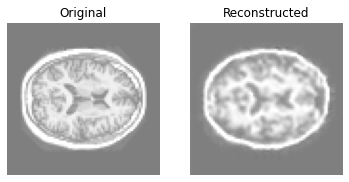

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


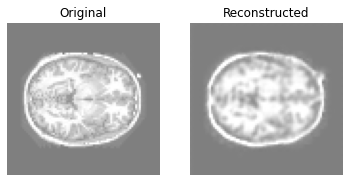

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


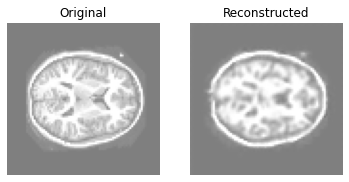

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


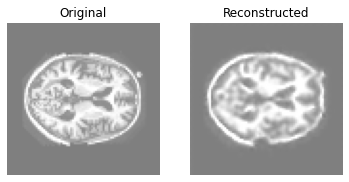

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


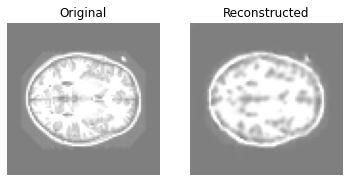

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


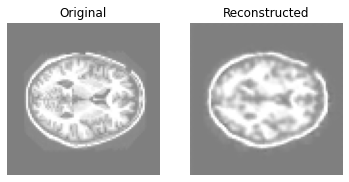

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


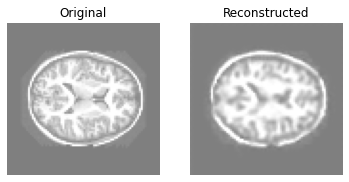

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


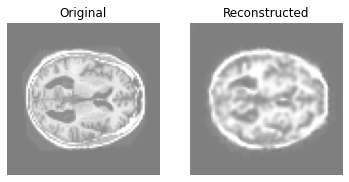

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


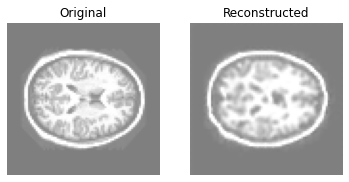

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


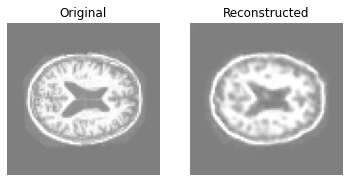

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


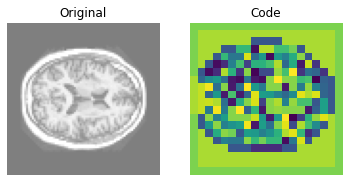

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


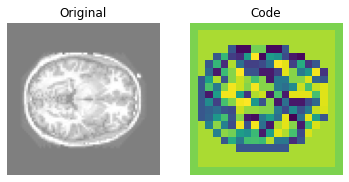

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


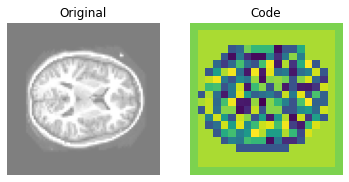

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


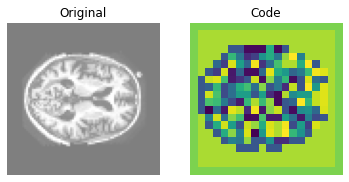

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


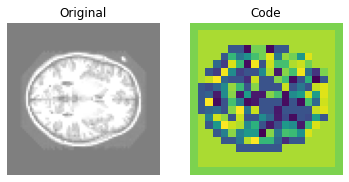

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


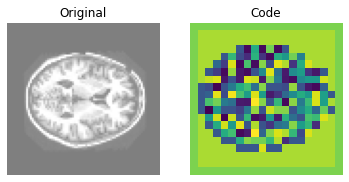

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


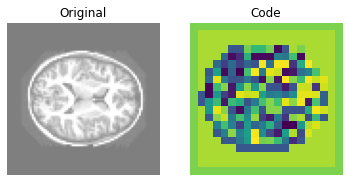

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


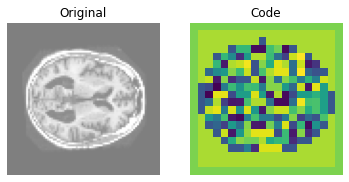

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


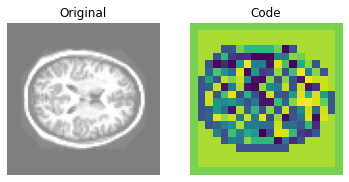

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


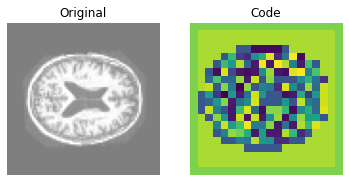

Average SSIM is:  tf.Tensor(0.84214693, shape=(), dtype=float32)


In [19]:
main()

In [ ]:
while True: pass